<h1>Riding services pricing for 12 months</h1>

<b>Description</b><br>
Maximization of a profit from a ride-hailing service is simulated as function of payment to drivers. Drivers work more as price goes up, so the dependency estimated with curve fitting. For each price in the range during 12 months, car pools of totally 10,000 potential riders simulated. Limitation of 1000 pulls per month taken into account. First, average of 30 simulations taken in price range 15-30 to find that optimal price is near 24. Then, 120 simulations per price in range 23-25 with smaller step. Optimal price found to be 24.00 with revenue 11,440.

In [ ]:
# import libraries
import warnings
import numpy as np
import pandas as pd
from scipy.stats import poisson
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
# settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [ ]:
# load data and drop duplicates
df = pd.read_csv('driverAcceptanceData.csv', index_col=0)
print(f"{df.shape[1]} columns, {df.shape[0]} rows")
# checking duplicated rows
print(f"{df.duplicated().sum()} duplicated rows")
print('removing duplicates...')
df.drop_duplicates(inplace=True)
print(f"{df.duplicated().sum()} duplicated rows")
df.head()

2 columns, 1000 rows
5 duplicated rows
removing duplicates...
0 duplicated rows


,PAY,ACCEPTED
0,29.358732,0
1,22.986847,0
2,18.020348,0
3,45.730717,1
4,14.642845,0


In [ ]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]
vars_with_na

[]

In [ ]:
# sort and index by PAY
df.sort_values(by='PAY', ascending=True, inplace=True)
df = df.reset_index(drop=True)

In [ ]:
# calculate cumupative probability of accepting the pay
df['CUM_ACCEPTED'] = 0
for row in range(len(df)):
    df.loc[row, "CUM_ACCEPTED"] = np.mean(df.ACCEPTED.values[:row+1])

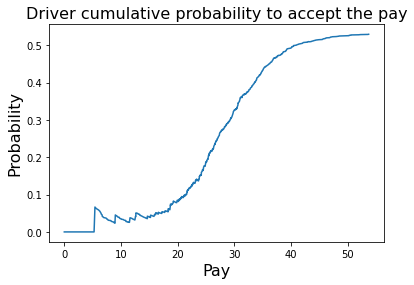

In [ ]:
# plot cumupative probability of accepting the pay
plt.plot(df.PAY, df.CUM_ACCEPTED)
plt.title("Driver cumulative probability to accept the pay", fontsize="16")
plt.xlabel("Pay", fontsize="16")
plt.ylabel("Probability", fontsize="16")
plt.show()

In [ ]:
# cut cumupative probability of accepting the pay
# to meaningful and clean values
df_pay = df[["PAY", "CUM_ACCEPTED"]].copy()
df_pay = df_pay[(df_pay.PAY >= 15) & (df_pay.PAY <= 30)]
print(*df_pay.shape)

498 2


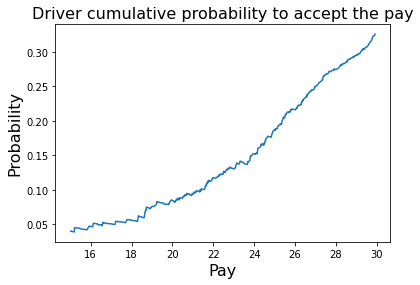

In [ ]:
# plot cumupative probability of accepting the pay
plt.plot(df_pay.PAY, df_pay.CUM_ACCEPTED)
plt.title("Driver cumulative probability to accept the pay", fontsize="16")
plt.xlabel("Pay", fontsize="16")
plt.ylabel("Probability", fontsize="16")
plt.show()

In [ ]:
# adjust curves for probability of accepting the pay
def adjR(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    return 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))

for order in range(2, 4):
    r2 = adjR(df_pay.PAY, df_pay.CUM_ACCEPTED, order)
    print(f"Odrer {order}, Pearson {r2:.4f}")

Odrer 2, Pearson 0.9940
Odrer 3, Pearson 0.9956


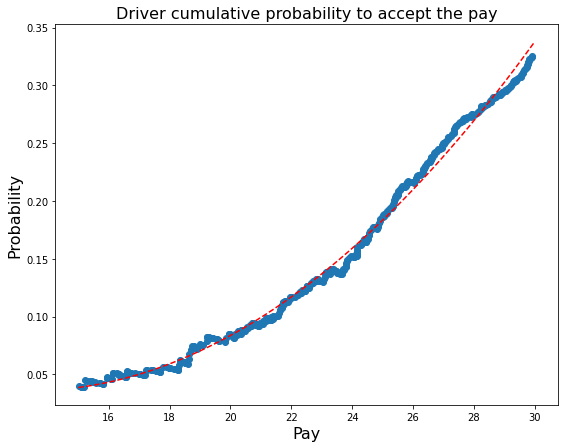

In [ ]:
# plot selected curve for probability of accepting the pay
model2 = np.poly1d(np.polyfit(df_pay.PAY, df_pay.CUM_ACCEPTED, 2))
polyline = np.linspace(15, 30, 50)
plt.figure(figsize=(9, 7))
plt.scatter(df_pay.PAY, df_pay.CUM_ACCEPTED)
plt.plot(polyline, model2(polyline), '--', color='red')
plt.title("Driver cumulative probability to accept the pay", fontsize="16")
plt.xlabel("Pay", fontsize="16")
plt.ylabel("Probability", fontsize="16")
plt.show()

In [ ]:
# print coefficients of the fitted curve
print(model2)

          2
0.001095 x - 0.02931 x + 0.2319


In [ ]:
# a function for calculation of cumulative
# of accepting the payment probability form pay
def accept_pay(pay, apps):
    proba =  0.001095*pay**2 - 0.02931*pay + 0.2319
    return np.sum(np.random.choice([0, 1], size=apps, p=[1-proba, proba]))

In [ ]:
# a function returning ride request probability
# based on amount of rides in previous month
def rides_per_month(lmbda):
    return np.random.poisson(lmbda)

In [ ]:
# function for monte carlo simulation of the revenue
def monte_carlo_revenue(pay, n_monte_carlo=30):

    # function to calculate rides
    def riders_rides(data):
        for idx, val in np.ndenumerate(data):
            applications = rides_per_month(val)
            data[idx] = accept_pay(pay=pay, apps=applications)   
        return data

    # function to calculate n_monte_carlo rides mean
    def n_rides_mean(riders_stock=10000, pool=1000, contract_len=12):
        df_matches = np.ones(pool, dtype='int')
        rides = 0

        for _ in range(contract_len):
            df_matches = riders_rides(df_matches)
            riders_stock -= len(df_matches[np.where(df_matches==0)])
            if riders_stock < 0:
                riders_stock = 0
            rides += np.sum(df_matches)
            zeros = df_matches[np.where(df_matches==0)].size
            # print(_, riders_stock, rides, zeros)
            df_matches = np.sort(df_matches)[::-1]
            if riders_stock >= zeros:
                df_matches[np.where(df_matches==0)] = 1
            else:
                new_len = pool + riders_stock - zeros
                df_matches = df_matches[:new_len]
                df_matches[np.where(df_matches==0)] = 1
        # print()
        return rides


    rides_list = [''] * n_monte_carlo
    for n in range(n_monte_carlo):
        rides_list[n] = n_rides_mean()

    margin = 30 - pay
    revenue = margin * np.mean(rides_list)
    # print(revenue)
    return revenue

  0%|          | 0/16 [00:00<?, ?it/s]

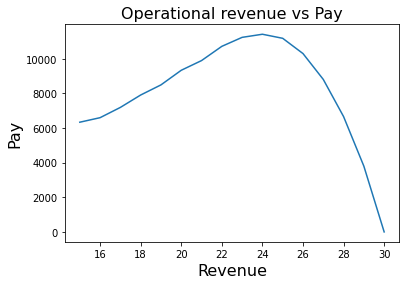

In [ ]:
# calculate preliminary boundary limit of maximum revenue
pays = np.linspace(15, 30, 16).tolist()
mc_list = [''] * len(pays)
for i, pay in enumerate(tqdm(pays)):
    mc_list[i] = monte_carlo_revenue(pay=pay)

plt.plot(pays, mc_list)
plt.title("Operational revenue vs Pay", fontsize="16")
plt.xlabel("Revenue", fontsize="16")
plt.ylabel("Pay", fontsize="16")
plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

Pay of 24.00 gives maximum revenue 11438.40



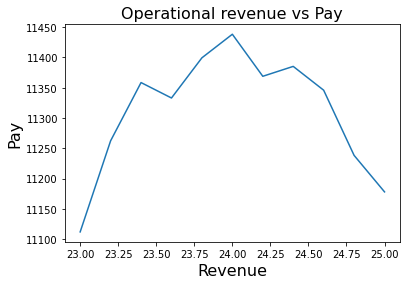

In [ ]:
# calculate maximum revenue
pays = np.linspace(23, 25, 11).tolist()
mc_list = [''] * len(pays)
for i, pay in enumerate(tqdm(pays)):
    mc_list[i] = monte_carlo_revenue(pay=pay, n_monte_carlo=120)

max_idx = np.argmax(mc_list)
max_pay = pays[max_idx]
max_rev = mc_list[max_idx]
print(f"Pay of {max_pay:.2f} gives maximum revenue {max_rev:.2f}", end='\n\n')

plt.plot(pays, mc_list)
plt.title("Operational revenue vs Pay", fontsize="16")
plt.xlabel("Revenue", fontsize="16")
plt.ylabel("Pay", fontsize="16")
plt.show()

END